In [2]:
import os
import numpy as np
import shutil
import random

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras import Model

from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D

In [3]:
#Organize Leaf data into train,validation and test directories
os.chdir('dataset_classes')

if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('validation')
    os.mkdir('test')
    
    for i in range(0,5):
        shutil.move(f'{i}','train')
        os.mkdir(f'validation/{i}')
        os.mkdir(f'test/{i}')
        
        validation_sample = random.sample(os.listdir(f'train/{i}'),159)
        for j in validation_sample:
            shutil.move(f'train/{i}/{j}',f'validation/{i}')
        
        test_sample = random.sample(os.listdir(f'train/{i}'),160)
        for k in test_sample:
            shutil.move(f'train/{i}/{k}',f'test/{i}')
os.chdir('../..')

In [4]:
train_data_path = r"E:\Semester 6\Project-Leaf_disease_classification\dataset_classes\train"
validation_data_path = r"E:\Semester 6\Project-Leaf_disease_classification\dataset_classes\validation"
test_data_path = r"E:\Semester 6\Project-Leaf_disease_classification\dataset_classes\test"

print('total training set1 images:', len(os.listdir(train_data_path)))


total training set1 images: 5


In [5]:
#TRAINING_DIR = r"E:\Semester 6\Project-Leaf_disease_classification\dataset_classes\train"
training_datagen = ImageDataGenerator(
                        rescale = 1./255)


#VALIDATION_DIR = r"E:\Semester 6\Project-Leaf_disease_classification\dataset_classes\validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)


In [6]:
train_generator = training_datagen.flow_from_directory(
    train_data_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 6360 images belonging to 5 classes.
Found 795 images belonging to 5 classes.


In [7]:
import math

BATCH_SIZE=32

TRAINING_SIZE = 6360

VALIDATION_SIZE = 795

# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = r'E:\Semester 6\Project-Leaf_disease_classification\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [9]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 12, 12, 768)


In [14]:
#Add a Conv2D layer
x = Conv2D(64,(2,2),activation='relu')(last_output)
#MaxPooling2D layer
#x = MaxPool2D()(x)
#GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(x)
# Flatten the output layer to 1 dimension
#x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)
# Add a final softmax layer for classification
x = layers.Dense(5, activation='softmax')(x)

In [15]:
# Configure and compile the model
model = Model(pre_trained_model.input, x)

model.summary()

optimizer = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
history = model.fit(
    train_generator, 
    epochs=15, 
    steps_per_epoch=steps_per_epoch, 
    validation_data = validation_generator,
    verbose = 1,
    validation_steps=val_steps)

Epoch 1/15
199/199 [==============================] - 447s 2s/step - loss: 1.1629 - accuracy: 0.6531 - val_loss: 0.5589 - val_accuracy: 0.8956
Epoch 2/15
199/199 [==============================] - 429s 2s/step - loss: 0.4042 - accuracy: 0.8994 - val_loss: 0.2284 - val_accuracy: 0.9610
Epoch 3/15
199/199 [==============================] - 404s 2s/step - loss: 0.2268 - accuracy: 0.9388 - val_loss: 0.1555 - val_accuracy: 0.9711
Epoch 4/15
199/199 [==============================] - 401s 2s/step - loss: 0.1646 - accuracy: 0.9538 - val_loss: 0.1196 - val_accuracy: 0.9711
Epoch 5/15
199/199 [==============================] - 403s 2s/step - loss: 0.1334 - accuracy: 0.9616 - val_loss: 0.1099 - val_accuracy: 0.9774
Epoch 6/15
199/199 [==============================] - 401s 2s/step - loss: 0.1084 - accuracy: 0.9701 - val_loss: 0.0820 - val_accuracy: 0.9836
Epoch 7/15
199/199 [==============================] - 401s 2s/step - loss: 0.0941 - accuracy: 0.9741 - val_loss: 0.0698 - val_accuracy: 0.9799

In [17]:
#!mkdir -p saved_model
model.save('saved_model/model_InceptionV3_trained_final')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/model_InceptionV3_trained_final\assets


Text(0.5, 1.0, 'Training and validation loss')

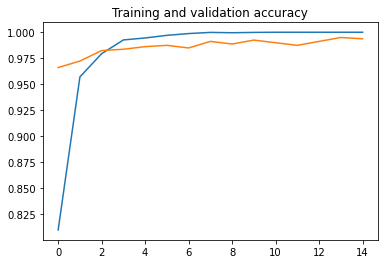

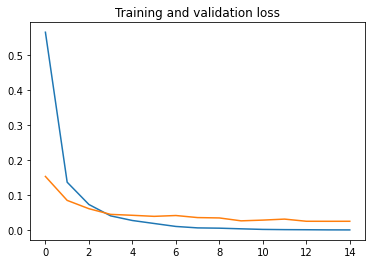

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

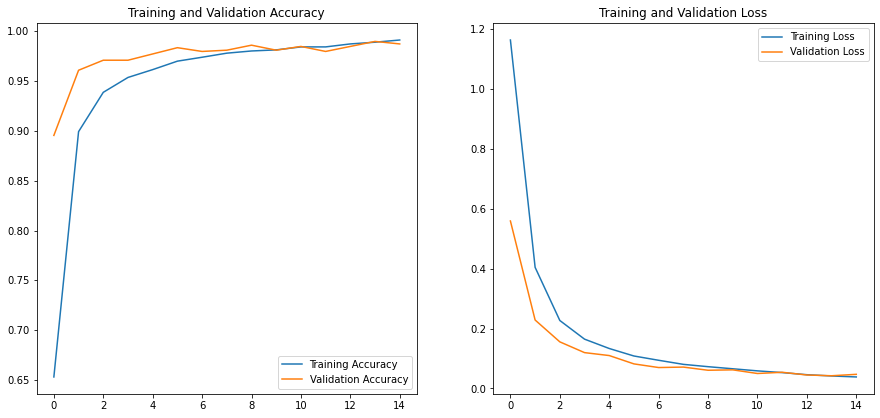

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools

In [20]:
#test_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator(rescale = 1./255)


test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 800 images belonging to 5 classes.


In [21]:
target_names = ['Bacterial_spot(Class 0)','Healthy(Class 1)','Late_blight(Class 2)','Septoria_leaf_spot(Class 3)','Yellow_curl_virus(Class 4)']

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()


    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")

    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


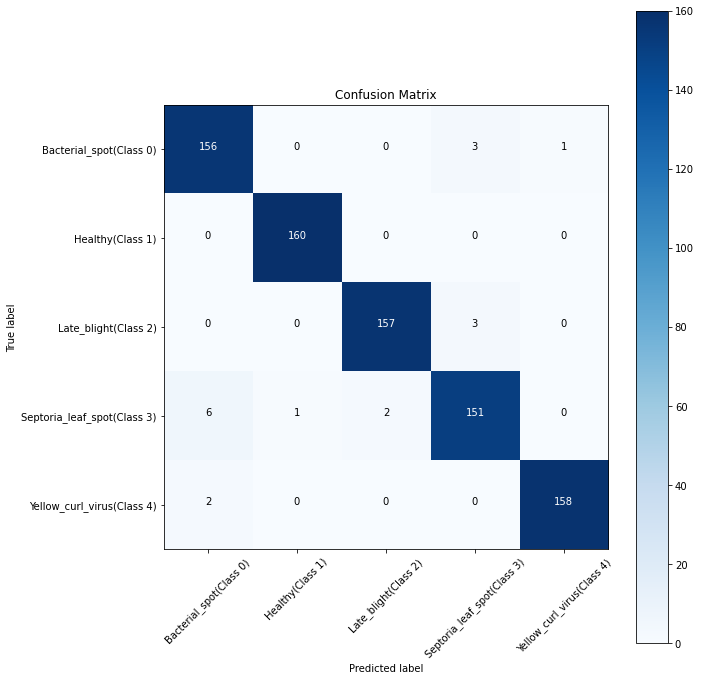

In [23]:
#Confution Matrix 

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


In [24]:
#Print Classification Report

print('Classification Report')

print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                             precision    recall  f1-score   support

    Bacterial_spot(Class 0)       0.95      0.97      0.96       160
           Healthy(Class 1)       0.99      1.00      1.00       160
       Late_blight(Class 2)       0.99      0.98      0.98       160
Septoria_leaf_spot(Class 3)       0.96      0.94      0.95       160
 Yellow_curl_virus(Class 4)       0.99      0.99      0.99       160

                   accuracy                           0.98       800
                  macro avg       0.98      0.98      0.98       800
               weighted avg       0.98      0.98      0.98       800



In [25]:
model.evaluate(test_generator)

25/25 [==============================] - 47s 2s/step - loss: 0.0741 - accuracy: 0.9775


[0.07409071177244186, 0.9775000214576721]